**This notebook is based on the paper:**

Electric Vehicles Driving Range and Energy Consumption Investigation: A Comparative Study of Machine Learning Techniques
https://ieeexplore.ieee.org/document/9066042

**Loading the dataset**
___

The dataset contains real-life driving data of two Volkswagen e-Golf cars, with year of manufacture as 2014 and 2016 respectively. The data is available at the Spritmonitor website.
Volkswagen e-Golf, year 2014, 85 kW (116 PS): https://www.spritmonitor.de/en/detail/679341.html?page=8
Volkswagen e-Golf, year 2016, 85kW (116 PS): https://www.spritmonitor.de/en/detail/786327.html
The data was scrapped using a python crawler (vehicle_crawler.py) available at: https://github.com/armiro/crawlers/tree/master/SpritMonitor-Crawler

The file includes data about 3615 trips with a total travel distance of around 152167 kilometers.

It is important to restrict the dataset to a limited number of cars. If data of the same type of car, owned by different people around the world, is included in the same dataset then it leads to instability in the model training. Hence, it is important to make sure that the dataset should not contain data of cars driven in too varied conditions.
Note: Some of the features were trimmed from the original CSV file before being loaded in the notebook.

In [1]:
import pandas as pd
import os

Notebook: https://hansalshah007.github.io/EV-Navigator/EV_Range_Prediction_(Volkswagen_Golf).html
data source: https://github.com/armiro/crawlers/tree/master/SpritMonitor-Crawler

In [2]:
file = "volkswagen_e_golf.csv"
cwd = os.getcwd()
if os.path.exists(os.path.join(cwd,file)):
    data_path = os.path.join(cwd,file)
    print("Selected File:",data_path)
else:
    print("Files and directories in '", cwd, "' :") 
    print(os.listdir(cwd))
    

Selected File: /home/sieglew/volkswagen_e_golf.csv


In [3]:
data =  pd.read_csv(data_path)
data.head()


,manufacturer,model,version,power(kW),fuel_date,trip_distance(km),quantity(kWh),fuel_type,tire_type,city,motor_way,country_roads,driving_style,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation
0,Volkswagen,Golf,e-Golf,85,08.02.2019,80,NaN,Electricity,Winter tires,0,0,1,Normal,17.8,0,1,53.0,1.0
1,Volkswagen,Golf,e-Golf,85,06.02.2019,50,12.29,Electricity,Winter tires,0,0,1,Normal,15.5,0,1,47.0,-1.3
2,Volkswagen,Golf,e-Golf,85,05.02.2019,43,8.68,Electricity,Winter tires,0,1,1,Normal,18.0,0,1,58.0,1.2
3,Volkswagen,Golf,e-Golf,85,04.02.2019,44,1.50,Electricity,Winter tires,0,1,1,Normal,16.1,0,1,43.0,-0.7
4,Volkswagen,Golf,e-Golf,85,04.02.2019,76,14.44,Electricity,Winter tires,0,1,0,Normal,19.0,0,1,76.0,2.2


**Checking the type of data in each column**
___

To check for categorical and non-categorical features in the dataset.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3345 entries, 0 to 3344
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   manufacturer            3345 non-null   object 
 1   model                   3345 non-null   object 
 2   version                 3345 non-null   object 
 3   power(kW)               3345 non-null   int64  
 4   fuel_date               3345 non-null   object 
 5   trip_distance(km)       3344 non-null   object 
 6   quantity(kWh)           3344 non-null   float64
 7   fuel_type               3345 non-null   object 
 8   tire_type               3345 non-null   object 
 9   city                    3345 non-null   int64  
 10  motor_way               3345 non-null   int64  
 11  country_roads           3345 non-null   int64  
 12  driving_style           3345 non-null   object 
 13  consumption(kWh/100km)  3345 non-null   float64
 14  A/C                     3345 non-null   

**Removing unnecessary features**
___
Since, the dataset contains data related to only one car i.e., Volkswagen Golf, the Manufacturer, Power(kW) of battery and other columns are constant. Hence, they can be safely dropped from the dataset, without leading to any loss of valuable information.

In [5]:
data.drop(['manufacturer','power(kW)', 'model','version','fuel_date','fuel_type'], axis=1, inplace=True)

**Removing all rows with missing values for Trip_Distance(km)**
___
All the rows/ records with missing values of Trip_Distance(km) should be removed. These values cannot be imputed, because this is the target variable.

In [6]:
data = data[data['trip_distance(km)'].isnull() == False]
data['trip_distance(km)'] = pd.to_numeric(data['trip_distance(km)'],errors='coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 0 to 3344
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trip_distance(km)       3341 non-null   float64
 1   quantity(kWh)           3343 non-null   float64
 2   tire_type               3344 non-null   object 
 3   city                    3344 non-null   int64  
 4   motor_way               3344 non-null   int64  
 5   country_roads           3344 non-null   int64  
 6   driving_style           3344 non-null   object 
 7   consumption(kWh/100km)  3344 non-null   float64
 8   A/C                     3344 non-null   int64  
 9   park_heating            3344 non-null   int64  
 10  avg_speed(km/h)         3332 non-null   float64
 11  ecr_deviation           3344 non-null   float64
dtypes: float64(5), int64(5), object(2)
memory usage: 339.6+ KB


**One-Hot Encoding the categorical variables (Types of tires and driving styles)**
___
The categorical variables cannot be used in the dataset for training the model. They have to be converted into a an integer representation of boolean form, i.e. 1/0

In [7]:
data.select_dtypes('object')

,tire_type,driving_style
0,Winter tires,Normal
1,Winter tires,Normal
2,Winter tires,Normal
3,Winter tires,Normal
4,Winter tires,Normal
...,...,...
3340,Winter tires,Normal
3341,Winter tires,Normal
3342,Winter tires,Normal
3343,Winter tires,Fast


In [8]:
print('Unique tire types:', data['tire_type'].unique())
print('Unique driving styles:', data['driving_style'].unique())

Unique tire types: ['Winter tires' 'Summer tires']
Unique driving styles: ['Normal' 'Fast' 'Moderate']


In [9]:
for each in data['tire_type'].unique():
    data['tire_type '+each] = list(map(int, data['tire_type']==each))

data.drop(['tire_type'], axis=1, inplace=True)

for each in data['driving_style'].unique():
    data['driving_style '+each] = list(map(int, data['driving_style']==each))

data.drop(['driving_style'], axis=1, inplace=True)

data.head()

,trip_distance(km),quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,avg_speed(km/h),ecr_deviation,tire_type Winter tires,tire_type Summer tires,driving_style Normal,driving_style Fast,driving_style Moderate
0,80.0,NaN,0,0,1,17.8,0,1,53.0,1.0,1,0,1,0,0
1,50.0,12.29,0,0,1,15.5,0,1,47.0,-1.3,1,0,1,0,0
2,43.0,8.68,0,1,1,18.0,0,1,58.0,1.2,1,0,1,0,0
3,44.0,1.50,0,1,1,16.1,0,1,43.0,-0.7,1,0,1,0,0
4,76.0,14.44,0,1,0,19.0,0,1,76.0,2.2,1,0,1,0,0


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3344 entries, 0 to 3344
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trip_distance(km)       3341 non-null   float64
 1   quantity(kWh)           3343 non-null   float64
 2   city                    3344 non-null   int64  
 3   motor_way               3344 non-null   int64  
 4   country_roads           3344 non-null   int64  
 5   consumption(kWh/100km)  3344 non-null   float64
 6   A/C                     3344 non-null   int64  
 7   park_heating            3344 non-null   int64  
 8   avg_speed(km/h)         3332 non-null   float64
 9   ecr_deviation           3344 non-null   float64
 10  tire_type Winter tires  3344 non-null   int64  
 11  tire_type Summer tires  3344 non-null   int64  
 12  driving_style Normal    3344 non-null   int64  
 13  driving_style Fast      3344 non-null   int64  
 14  driving_style Moderate  3344 non-null   int64

**Shuffling and splitting the data into training and test sets**
___
Dividing the dataset into features (X) and label (Y)

In [11]:
data = data.sample(frac=1)

Y = data['trip_distance(km)']
X = data.drop(['trip_distance(km)'], axis=1)

X.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
Y.reset_index(level=None, drop=True, inplace=True)

Dividing the features into training (80%) and testing (20%) datasets for model training and evaluation respectively

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=1)

X_train.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
X_test.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
Y_train.reset_index(level=None, drop=True, inplace=True)
Y_test.reset_index(level=None, drop=True, inplace=True)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(2675, 14) (2675,) (669, 14) (669,)


**Imputing columns with missing values in training set**
___
Missing values for numerical/ non-categorical features is to be imputed using the rest of the data in the same feature.

In [13]:
X_train.isnull().any()

quantity(kWh)              True
city                      False
motor_way                 False
country_roads             False
consumption(kWh/100km)    False
A/C                       False
park_heating              False
avg_speed(km/h)            True
ecr_deviation             False
tire_type Winter tires    False
tire_type Summer tires    False
driving_style Normal      False
driving_style Fast        False
driving_style Moderate    False
dtype: bool

Here, we have used a simple imputer using the 'mean strategy', i.e. the missing values will be replaced by the mean of non-missing values in that feature.

In [14]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')

cols_with_missing_data = [cols for cols in X_train.columns if X_train[cols].isnull().any()]
X_train_imputed_data_columns = pd.DataFrame(imputer.fit_transform(X_train[cols_with_missing_data]))
X_test_imputed_data_columns = pd.DataFrame(imputer.transform(X_test[cols_with_missing_data]))

X_train_imputed_data_columns.columns = cols_with_missing_data
X_test_imputed_data_columns.columns = cols_with_missing_data

X_train = pd.concat([X_train.drop(cols_with_missing_data, axis=1, inplace=False), X_train_imputed_data_columns], axis=1)
X_test = pd.concat([X_test.drop(cols_with_missing_data, axis=1, inplace=False), X_test_imputed_data_columns], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2675 entries, 0 to 2674
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    2675 non-null   int64  
 1   motor_way               2675 non-null   int64  
 2   country_roads           2675 non-null   int64  
 3   consumption(kWh/100km)  2675 non-null   float64
 4   A/C                     2675 non-null   int64  
 5   park_heating            2675 non-null   int64  
 6   ecr_deviation           2675 non-null   float64
 7   tire_type Winter tires  2675 non-null   int64  
 8   tire_type Summer tires  2675 non-null   int64  
 9   driving_style Normal    2675 non-null   int64  
 10  driving_style Fast      2675 non-null   int64  
 11  driving_style Moderate  2675 non-null   int64  
 12  quantity(kWh)           2675 non-null   float64
 13  avg_speed(km/h)         2675 non-null   float64
dtypes: float64(4), int64(10)
memory usage: 2

Checking the number of non-null values in each column of the dataset

In [15]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    669 non-null    int64  
 1   motor_way               669 non-null    int64  
 2   country_roads           669 non-null    int64  
 3   consumption(kWh/100km)  669 non-null    float64
 4   A/C                     669 non-null    int64  
 5   park_heating            669 non-null    int64  
 6   ecr_deviation           669 non-null    float64
 7   tire_type Winter tires  669 non-null    int64  
 8   tire_type Summer tires  669 non-null    int64  
 9   driving_style Normal    669 non-null    int64  
 10  driving_style Fast      669 non-null    int64  
 11  driving_style Moderate  669 non-null    int64  
 12  quantity(kWh)           669 non-null    float64
 13  avg_speed(km/h)         669 non-null    float64
dtypes: float64(4), int64(10)
memory usage: 73.

**Outlier Analysis**
___
This analysis is performed on continuos features assuming that they are having Gaussian distribution. The data points having a z-score of more than 3 and less than -3 are removed from the dataset since they are considered as outliers.

Outlier analysis is used for identifying outlying continuous data. In our dataset Quantity(kWh) & Avg_Speed(km/h) are the only continuos data apart from the target variable.

In [16]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

**For Average Speed (km/hr)**

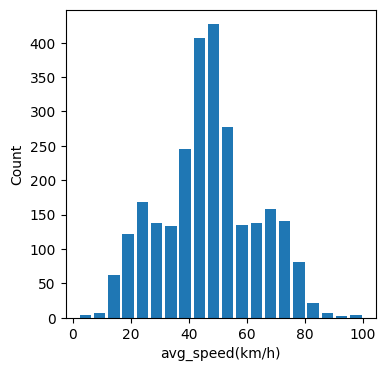

In [17]:
plt.figure(figsize=(4,4))
plt.hist(X_train['avg_speed(km/h)'], bins=20, rwidth=0.8)
plt.xlabel('avg_speed(km/h)')
plt.ylabel('Count')
plt.show()

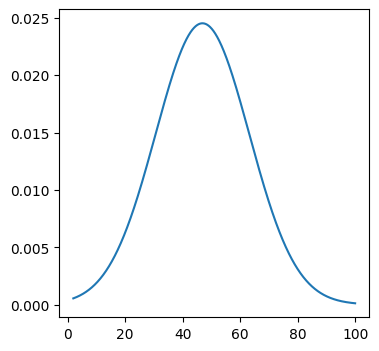

In [18]:
plt.figure(figsize=(4,4))
rng = np.arange(X_train['avg_speed(km/h)'].min(), X_train['avg_speed(km/h)'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, X_train['avg_speed(km/h)'].mean(), X_train['avg_speed(km/h)'].std()))
plt.show()

It could be cleary seen from the bell shaped curve that the data for average speed is normalized. Thus removing outliers depending upon the z-score

In [19]:
X_train['speed_z_score'] = (X_train['avg_speed(km/h)'] - X_train['avg_speed(km/h)'].mean())/X_train['avg_speed(km/h)'].std()
X_test['speed_z_score'] = (X_test['avg_speed(km/h)'] - X_test['avg_speed(km/h)'].mean())/X_test['avg_speed(km/h)'].std()

# Removing inputes with z-score of more than 3 or less than -3 for average speed
to_be_included_train = (X_train['speed_z_score'] < 2) | (X_train['speed_z_score'] > -2)
to_be_included_test = (X_test['speed_z_score'] < 2) | (X_test['speed_z_score']>-2)

X_train = X_train[to_be_included_train]
Y_train = Y_train[to_be_included_train]

X_test = X_test[to_be_included_test]
Y_test = Y_test[to_be_included_test]

X_train.drop(['speed_z_score'], axis=1, inplace=True)
X_test.drop(['speed_z_score'], axis=1, inplace=True)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(2675, 14) (2675,) (669, 14) (669,)


**For Quantity(kWh)**

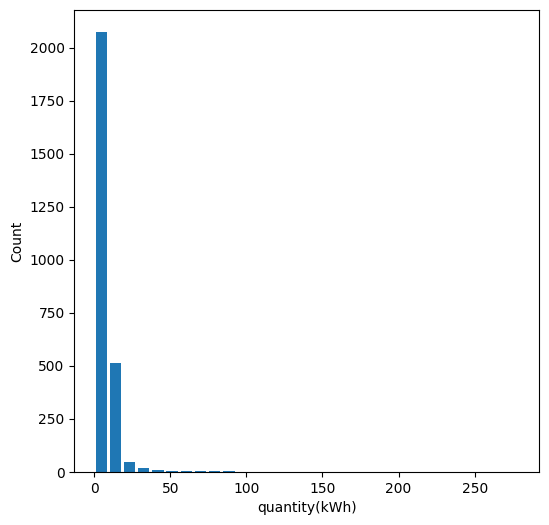

In [20]:
plt.figure(figsize=(6,6))
plt.hist(X_train['quantity(kWh)'], bins=30, rwidth=0.8)
plt.xlabel('quantity(kWh)')
plt.ylabel('Count')
plt.show()

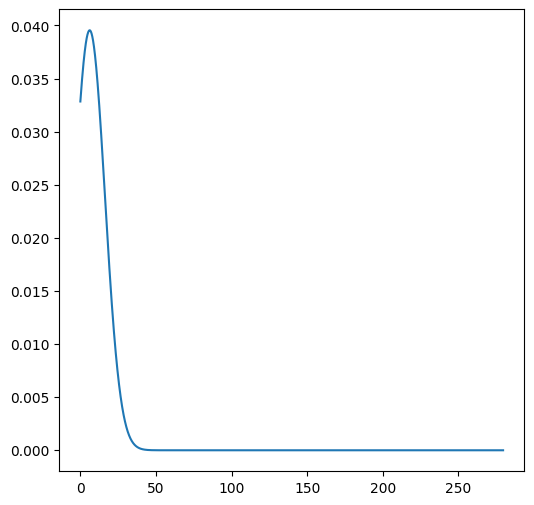

In [21]:
plt.figure(figsize=(6,6))
rng = np.arange(X_train['quantity(kWh)'].min(), X_train['quantity(kWh)'].max(), 0.1)
plt.plot(rng, norm.pdf(rng, X_train['quantity(kWh)'].mean(), X_train['quantity(kWh)'].std()))
plt.show()

From the curve it is concluded that the quantity(kWh) is not distributed normally. Hence, removing all the rows with quantity(kWh) greater than 60kWh

In [22]:
to_be_included_train = X_train['quantity(kWh)']<=80
to_be_included_test = X_test['quantity(kWh)']<=80

X_train = X_train[to_be_included_train]
Y_train = Y_train[to_be_included_train]

X_test = X_test[to_be_included_test]
Y_test = Y_test[to_be_included_test]

X_train.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
X_test.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
Y_train.reset_index(level=None, drop=True, inplace=True)
Y_test.reset_index(level=None, drop=True, inplace=True)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(2671, 14) (2671,) (668, 14) (668,)


**Correlation between different features**
___

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

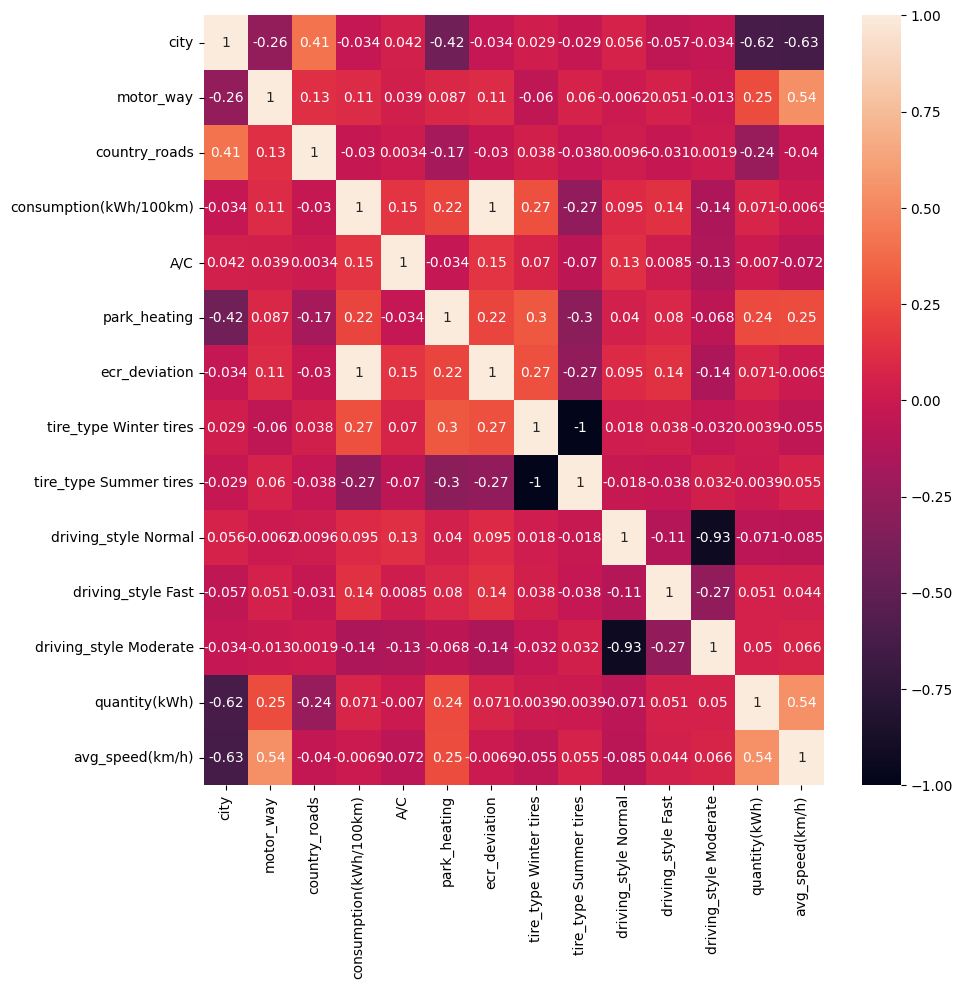

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(X_train.corr(method='pearson'), annot=True)
plt.show()

As it could be seen from the heatmap that the Driving_Style Normal & Driving_Style Moderate are possessing strong negative correlation, one of them needs to be dropped. Same goes for Summer & winter tire types.

In [25]:
X_train = X_train.drop(['driving_style Normal', 'tire_type Summer tires'], axis=1)
X_test = X_test.drop(['driving_style Normal', 'tire_type Summer tires'], axis=1)

**Tensorflow Model**
___
Preparing a neural network model in tensorflow for this regression problem.

In [30]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import regularizers

import torch

**Normalizing the continuos features before feeding it to the neural net**

In [31]:
cols_to_be_normalized = ['quantity(kWh)', 'avg_speed(km/h)']

for each in cols_to_be_normalized:
    mean = X_train[each].mean()
    std = X_train[each].std()

    X_train[each] = (X_train[each] - mean)/std
    X_test[each] = (X_test[each] - mean)/std

In [34]:
# Cuda settings:

torch.cuda.current_device()
#tf.config.list_physical_devices('GPU')
torch.cuda.set_device(1)


1

In [28]:
X_train

,quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,ecr_deviation,tire_type Winter tires,driving_style Fast,driving_style Moderate,avg_speed(km/h)
0,0.213231,1,1,0,11.6,0,0,-5.2,0,0,0,0.995772
1,0.773593,0,0,1,14.7,0,1,-2.1,1,0,0,0.256544
2,1.195976,1,0,1,14.1,0,0,-2.7,1,0,1,1.488591
3,1.212871,1,1,1,13.2,0,0,-3.6,0,0,1,0.071737
4,-0.654063,1,0,0,18.0,0,0,1.2,1,0,1,-1.591528
...,...,...,...,...,...,...,...,...,...,...,...,...
2667,1.615543,0,1,0,14.8,0,1,-2.0,1,0,1,1.180579
2668,1.336770,0,1,0,10.2,0,0,-6.6,0,0,1,1.858206
2669,-0.302077,1,1,1,18.8,0,1,2.0,1,0,1,-0.113071
2670,-0.259838,1,1,1,20.3,0,0,3.5,1,0,1,0.626158


In [29]:
X_test

,quantity(kWh),city,motor_way,country_roads,consumption(kWh/100km),A/C,park_heating,ecr_deviation,tire_type Winter tires,driving_style Fast,driving_style Moderate,avg_speed(km/h)
0,0.559585,0,1,0,13.9,0,1,-2.9,1,0,1,0.564556
1,-0.573810,1,0,0,13.1,0,0,-3.7,0,0,0,-1.406721
2,-0.578034,1,1,1,8.9,0,0,-7.9,1,0,1,-0.359480
3,-0.344315,1,1,1,17.3,0,0,0.5,0,0,1,0.133339
4,0.855253,0,1,0,11.2,0,0,-5.6,0,0,1,1.611796
...,...,...,...,...,...,...,...,...,...,...,...,...
661,0.407527,0,1,0,13.4,0,0,-3.4,0,0,1,1.550194
662,-0.648431,1,1,1,6.2,0,0,-10.6,0,0,1,0.256544
663,-0.392185,0,1,0,16.9,0,1,0.1,1,0,1,0.133339
664,-0.280958,0,1,0,18.2,0,1,1.4,1,0,1,-0.113071


**Bulding a sequential model**
___

In [30]:
model = Sequential()
#model.add(keras.Input(shape=(len(X_train.columns),)))

model.add(Dense(units=32, activation='relu', input_dim=len(X_train.columns)))

model.add(Dense(units=32, activation='relu'))

#model.add(Dense(units=5, activation='relu'))
#model.add(Dense(units=3, activation='relu'))

model.add(Dense(units=1, activation='linear')) 

#Your final Dense, naturally, needs to have 1 unit only. For regression you might want activation = 'linear' in the last layer and for classification you will want 'sigmoid'.

batch_size = 16     # batch size for model fitting

epochs = 1000       # number of epochs for model fitting

STEPS_PER_EPOCH = X_train.shape[0]/batch_size

es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=0) # Early stopping to prevent overfitting
 
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(                  # Using a dynamic learning rate that decays a certain rate per 100 epochs
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=0.98,
  staircase=False)        

opt = keras.optimizers.RMSprop(lr_schedule)   # Using RMSprop optimizer with the learning rate schedule as mentioned above
#opt = keras.optimizers.Adam(lr_schedule)   

model.compile(loss='mae', optimizer=opt, metrics=['mae'])
model.summary()

/home/sieglew/.local/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-08-05 13:20:35.088296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 468 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-08-05 13:20:35.090265: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 42980 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:21:00.0, compute capability: 8.9
2024-08-05 13:20:35.092554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 43409 MB mem

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,505 (5.88 KB)

 Trainable params: 1,505 (5.88 KB)

 Non-trainable params: 0 (0.00 B)

Fitting the model to the training data

In [31]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, callbacks=[es], validation_split=0.2, validation_data=None, verbose=1)

Epoch 1/1000


I0000 00:00:1722856835.857921  937376 service.cc:146] XLA service 0x7fe2a8006410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722856835.857959  937376 service.cc:154]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1722856835.857962  937376 service.cc:154]   StreamExecutor device (1): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1722856835.857965  937376 service.cc:154]   StreamExecutor device (2): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1722856835.857967  937376 service.cc:154]   StreamExecutor device (3): NVIDIA L40, Compute Capability 8.9
2024-08-05 13:20:35.871840: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 13:20:35.958678: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 73/134 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - loss: 41.2537 - mae: 41.2537

I0000 00:00:1722856836.327174  937376 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 38.4917 - mae: 38.4917 - val_loss: 25.3560 - val_mae: 25.3560
Epoch 2/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.0613 - mae: 25.0613 - val_loss: 22.5465 - val_mae: 22.5465
Epoch 3/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23.0928 - mae: 23.0928 - val_loss: 18.4341 - val_mae: 18.4341
Epoch 4/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.2461 - mae: 17.2461 - val_loss: 14.7882 - val_mae: 14.7882
Epoch 5/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.9471 - mae: 14.9471 - val_loss: 13.6643 - val_mae: 13.6643
Epoch 6/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.3254 - mae: 13.3254 - val_loss: 13.3247 - val_mae: 13.3247
Epoch 7/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.9418 - mae: 12.9418 - val_loss: 12.6025 - val_mae: 12.6025
Epoch 8/1000
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5957 - mae: 12.5957 - val_loss: 11.9997 - val_mae: 11.9997
Epoch 9/1000
134/134 

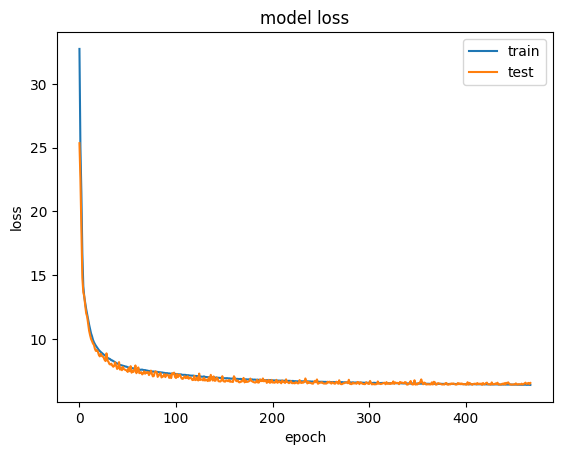

In [32]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
plot_history(history)

NameError: name 'plot_history' is not defined

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
        
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    

    if len(acc_list) == 0:
        print('Accuracy is missing in history')
        return 

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Making predictions for the test dataset and evaluating the model on the basis of mean absolute error**

In [ ]:
from sklearn.metrics import mean_absolute_error
predictions = (model.predict(X_test))
print(mean_absolute_error(Y_test, predictions))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5.272069966037949


In [ ]:
compare = pd.concat([pd.DataFrame(predictions), pd.DataFrame(Y_test)], axis=1)
compare.columns = ['Predictions', 'Actual Output']
compare

,Predictions,Actual Output
0,9.037865,9.0
1,20.194204,21.0
2,20.584341,20.0
3,20.032333,22.0
4,20.328135,20.0
...,...,...
663,9.030554,12.0
664,35.665607,36.0
665,79.745483,84.0
666,89.037949,101.0


**Calculating the standard deviation of the test labels**


In [ ]:
Y_test.std()

42.10963635373638

**Saving and exporting JSON version of the model**
___

In [ ]:
#import tensorflowjs

model.save(os.path.join(cwd,'range_prediction_model.h5'))
#tensorflowjs.converters.save_keras_model(model, '/content/drive/MyDrive/Colab Notebooks/Projects/EV Range Prediction/Model (Final)/JSON')

: 